In [96]:
# import functions from my_functions.py file
import sys
sys.path.append('/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start')
from my_functions import *

In [97]:
#-- Select the variable of interest
variable = "PW"

In [98]:
#-- Condition if Precac; Load segmentation relation file 
if variable == "Precac":
    df = loadRelTable()
    num_df_files = len(df['path_dyamond'])
    num_df_files = 200 ### For testing

In [99]:
#-- Condition if not Precac; Search for files containing the desired characters
if not variable == "Precac":
    matching_files = glob.glob(path_2D + '/*{}*'.format(variable))
    sorted_files = sorted(matching_files)
    sorted_files = sorted_files[:200] ### For testing

In [100]:
#-- initialize lists containing spatial mean over time and the times
data_list = [] 
timestamp_list = []

In [101]:
#-- Iterate through the timestamps and populate the arrays with a progress bar

from tqdm import tqdm

if not variable == "Precac":
    
    for i, file in tqdm(enumerate(sorted_files), total=len(sorted_files), desc='Processing'):

        # Access data
        data = xr.open_dataset(file)
        variable_data = data[variable]
        
        # Calculate spatial mean
        mean_lonlat = variable_data.mean(dim=['lon', 'lat'])
        mean_lonlat_value = mean_lonlat.values[0]

        # Getting timestamp
        start_marker = "DYAMOND_9216x4608x74_7.5s_4km_4608_"
        end_marker = f".{variable}.2D.nc"

        start_index = file.index(start_marker) + len(start_marker)
        end_index = file.index(end_marker)

        time_stamp = file[start_index:end_index]

        # Append to lists
        data_list.append(mean_lonlat_value)
        timestamp_list.append(time_stamp)
        
        # Delete data and remove from memory
        del data
        del mean_lonlat
        del mean_lonlat_value
        del variable_data
        gc.collect
        
else:
    
    for seg_index in tqdm(range(num_df_files), desc='Processing'):
        
        # Handling edge case: making data the same for 0 and 1 index
        if seg_index == 0:
                seg_index = 1

        # Load data
        prec = loadPrec(seg_index,df)
        prec_filename = loadPrecacFilename(seg_index, df)
        time_stamp = prec_filename[119:129]

        # Replace negative values with NaN
        variable_data = xr.where(prec < 0, np.nan, prec)
        
        # Calculate spatial mean

        mean_lonlat = variable_data.mean(dim=['lon', 'lat'])
        mean_lonlat_value = mean_lonlat.item()  # Convert scalar to a Python float
    
        
        # Append to lists
        data_list.append(mean_lonlat_value)
        timestamp_list.append(time_stamp)

        # Delete data and remove from memory
        del prec
        del prec_filename
        del variable_data
        gc.collect
        

# Convert lists to arrays
data = np.array(data_list)
timestamps_array = np.array(timestamp_list)

# Print the resulting array
print(data)
print(timestamps_array)

Processing:   0%|                                   | 0/200 [00:00<?, ?it/s]Exception ignored in: <function CachingFileManager.__del__ at 0x7f80b1d26b00>
Traceback (most recent call last):
  File "/home/gmaxemin/anaconda3/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 248, in __del__
    self.close(needs_lock=False)
  File "/home/gmaxemin/anaconda3/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 232, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2607, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2570, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2014, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: No such device
Processing: 100%|█████████████████████████| 200/200 [00:32<00:00,  6.17it/s]

[57.22739  57.210747 57.178886 57.14722  57.103394 57.040825 56.97231
 56.915604 56.871063 56.827904 56.773804 56.726097 56.696236 56.678646
 56.66154  56.641727 56.613342 56.585915 56.559006 56.540127 56.52732
 56.517834 56.504726 56.503372 56.51687  56.512264 56.510876 56.53152
 56.560543 56.589653 56.61849  56.64356  56.66942  56.700764 56.74657
 56.799603 56.84453  56.885685 56.931297 56.97796  57.022602 57.048912
 57.06835  57.082005 57.100132 57.115913 57.123524 57.118813 57.113552
 57.113075 57.097332 57.075924 57.05176  57.014923 56.97079  56.917377
 56.850338 56.78684  56.734783 56.690056 56.633854 56.580376 56.53023
 56.475662 56.41882  56.37017  56.31137  56.256344 56.217083 56.195255
 56.16494  56.125576 56.076458 56.02826  56.00549  56.002068 55.99404
 55.994045 56.005207 56.02087  56.030697 56.027756 56.01968  56.025723
 56.03109  56.02018  56.00302  55.99317  56.001343 56.020267 56.05412
 56.090843 56.11266  56.11393  56.109154 56.100136 56.088398 56.07314
 56.046196 56.

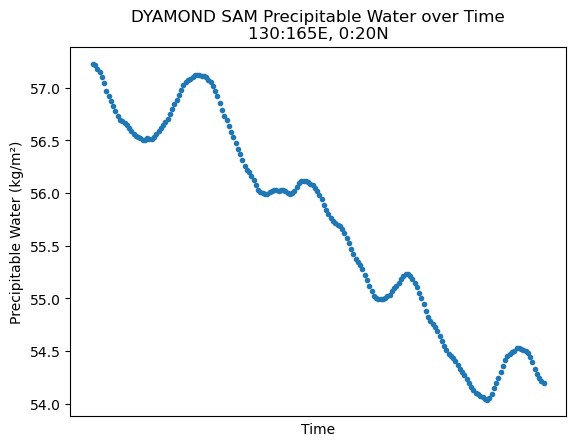

In [102]:
#-- plotting

name_dict = {"OM500":"Pressure velocity at 500 mb", "T2mm":"2-m temperature", "OM850":"Pressure velocity at 850 mb", "Precac":"Surface Accum Precip.", "PW":"Precipitable Water", "CWP":"Cloud Water Path", "U10m":"10-m zonal wind", "RH500":"Relative Humidity 500mb", "PSFC":"P at the surface","V10m":"10-m meridional wind","SHF":"Sensible Heat Flux", "LHF":"Latent Heat Flux"}
unit_dict = {"OM500":"Pa/s","T2mm":"K", "OM850":"Pa/s","Precac":"mm", "PW":"kg/m²", "CWP":"kg/m²", "U10m":"m/s", "RH500":"", "PSFC":"mbar", "V10m":"m/s","SHF":"W/m²", "LHF":"W/m²"}
var_name = name_dict.get(variable)
var_unit = unit_dict.get(variable)


# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
ax.plot(timestamps_array, data, marker='.', linestyle='none')
ax.set_xlabel('Time')
ax.set_ylabel(f'{var_name} ({var_unit})')
ax.set_title(f'DYAMOND SAM {var_name} over Time\n130:165E, 0:20N')


plt.xticks([])

# Save the plot to the specified folder
save_folder = "/home/gmaxemin/code/stage-2023-rain-extremes-timing-intensity/scripts/start/convolution/plots"
save_path = os.path.join(save_folder, f'{variable}_timeseries_test1.png')
plt.savefig(save_path)

plt.show()